In [2]:
import os
import json
import copy
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
import sys
sys.dont_write_bytecode = True
sys.path.append('../')
from tools.maneger import DataManager
from tools.preproc import Preprocessor
# from utterance.feature import Feature
from feature import Feature

/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [4]:
path = '../error_category_classification/dbdc5_ja_dev_labeled/'
datalist = ['DCM', 'DIT', 'IRS']
# datalist = ['DCM']
    # List of error types
error_types = ['Unclear intention', 'Wrong information',
    'Ignore question', 'Topic transition error', 
    'Lack of information', 'Repetition', 
    'Contradiction', 'Self-contradiction',
    'Lack of common sense', 'Semantic error',
    'Grammatical error', 'Ignore proposal', 
    'Ignore offer', 'Lack of sociality', 
    'Uninterpretable', 'Ignore greeting', 
    'No-Err']

pre = Preprocessor()
df = pre.read_json_with_NoErr(path, datalist)

300


In [5]:
F_path = "../X_y_data/response/"
F_name = "typeClassify_F.dill"
featureM = DataManager(F_path, format_="dill")

F = featureM.load_data(F_name)
F.set_preprocessor(pre)

success load : ../X_y_data/response/typeClassify_F.dill


In [6]:
model_path = "../models/response/"
model_name = "typeClassify_M.pickle"
modelM = DataManager(model_path)

lr = modelM.load_data(model_name)

success load : ../models/response/typeClassify_M.pickle


In [7]:
label_list = "YN WH please plain".split()
label_dict = dict( zip(label_list, range(len(label_list))) )
label_dict2 = dict( zip(range(len(label_list)), label_list) )

In [8]:
def extract_no_error_particular(df, mode):
    prev_u = ""
    utterances = []
    for d, u, s, e in zip(df.did, df.usr, df.sys, df.ec):
        # print(type(u))
        f = F.featurization(s)
        y = lr.predict(f.reshape(1,-1))
        if mode=="question":
            if y == 0 or y == 1:
                # print("y: {0}, s: {1}, \n u: {2}\n".format(label_dict2[int(y)], s, prev_u))
                utterances.append([s, prev_u])
        elif mode=="please":
            if y == 3:
                utterances.append([s, prev_u])
        prev_u = u
    return utterances


In [9]:
def extract_error(df, errors):
    utterances = []
    for d, u, s, e in zip(df.did, df.usr, df.sys, df.ec):
        for err in errors:
            if err in e:
                utterances.append([u, s])
    return utterances

In [10]:
errors = ["Ignore question"]

In [11]:
igque = extract_error(df, errors)

In [12]:
igque_no = extract_no_error_particular(df, mode="question")

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import loss
import torch.optim as optim

torch.cuda.is_available()

True

In [14]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, tagset_size, batch_size):
        # 親クラスのコンストラクタ。決まり文句
        super(LSTMClassifier, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。    
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        # LSTMの隠れ層。これ１つでOK。超便利。
        self.lstm = nn.LSTM(embedding_dim, hidden_dim//2, batch_first=True, bidirectional=True )
        # LSTMの出力を受け取って全結合してsoftmaxに食わせるための１層のネットワーク
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
        # self.softmax = 
    
    def forward(self, x):
        #embeds.size() = (batch_size × len(sentence) × embedding_dim)
        batch_size, seq_len = x.shape[0], x.shape[1]
        _, hidden_layer = self.lstm(x)
        # print(hidden_layer)
        bilstm_out = torch.cat([hidden_layer[0][0], hidden_layer[0][1]], dim=1)
        # y = self.hidden2tag(hidden_layer[0].view(batch_size, -1))

        y = self.hidden2tag(bilstm_out)
        y = F.log_softmax(y, dim=1)
        return y

In [15]:
class Datasets(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        # self.transform = transform

        self.X_data = X_data
        self.y_data = y_data

        self.datanum = len(X_data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_X = self.X_data[idx]
        out_y = self.y_data[idx]

        return out_X, out_y

In [16]:
from pyknp import Juman
from sentence_transformers import SentenceTransformer
import scipy.spatial
model_path = "/home/yamada/Downloads/training_bert_japanese"
Nmodel = SentenceTransformer(model_path, show_progress_bar=False)
emb_dim = Nmodel.encode(["お辞儀をしている男性会社員"])[0].shape[0]

In [17]:
def make_X(convs):
    X_data = []
    
    for conv in convs :
        sentence_vectors = Nmodel.encode(conv)
        X_data.append(sentence_vectors)
    return np.array(X_data)

In [18]:
data_path = "../X_y_data/response/"
data_name = "question1.pickle"
dataM = DataManager(data_path)
print(data_name)

question1.pickle


In [19]:
if dataM.is_exist(data_name):
    
    DATA_Xy = dataM.load_data(data_name)
    X = DATA_Xy[0]
    y = DATA_Xy[1]
else:
    # X_data, y_data = pre.extract_X_y(df, error_types, seq_len)
    X = make_X(igque + igque_no)
    y = np.concatenate( [ np.ones(len(igque)), np.zeros(len(igque_no)) ] )
    dataM.save_data(data_name, [X, y])

success load : ../X_y_data/response/question1.pickle


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

In [21]:
leng = len(y_train)
print(leng)
for i, v in enumerate(y_train):
    if leng %(i+1) == 0:
        print(i+1, end=", ")

405
1, 3, 5, 9, 15, 27, 45, 81, 135, 405, 

In [39]:
BATCH_SIZE = 81
epoch_ = 600
trainset = Datasets(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [40]:
EMBEDDING_DIM = emb_dim
HIDDEN_DIM = emb_dim*4
OUTPUT_DIM = 2
# seq_len = length

In [41]:
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, BATCH_SIZE)
if torch.cuda.is_available():
   model.cuda()
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [42]:
losses = []
loss_border = 0.0001
# print("error[{0}]".format(error_types[error_i]))
for epoch in range(epoch_):  # again, normally you would NOT do 300 epochs, it is toy data
    all_loss = 0
    for data in trainloader:
        X_t_tensor = torch.tensor(data[0], device='cuda:0').float()
        # y_t_tensor = torch.tensor(data[1].reshape(batch_size, 1), device='cuda:0').float()
        y_t_tensor = torch.tensor(data[1], device='cuda:0').long()
        optimizer.zero_grad()
        model.zero_grad()
        # print(X_t_tensor.shape)

        score = model(X_t_tensor)
        loss_ = loss_function(score, y_t_tensor)
        loss_.backward()
        all_loss += loss_.item()
        optimizer.step()
        del score
        del loss_
    losses.append(all_loss)
    if (epoch+1) % 50 == 0:
        print("epoch", epoch+1, "\t" , "loss", all_loss)
print("done")

/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/yamada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


epoch 50 	 loss 0.00013331559421203565
epoch 100 	 loss 5.521647744899383e-05
epoch 150 	 loss 2.9905065275670495e-05
epoch 200 	 loss 1.8595072333482676e-05
epoch 250 	 loss 1.2578740324897808e-05
epoch 300 	 loss 8.98923917702632e-06
epoch 350 	 loss 6.70514157263824e-06
epoch 400 	 loss 5.128935185894079e-06
epoch 450 	 loss 4.006016581570293e-06
epoch 500 	 loss 3.1906852768770477e-06
epoch 550 	 loss 2.5799228069445235e-06
epoch 600 	 loss 2.113388404723082e-06
done


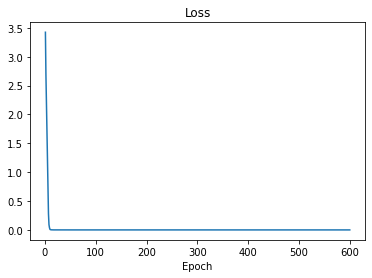

In [45]:
from matplotlib import pyplot as plt
def plot_history(losses):
    fig, ax = plt.subplots()

    epochs = np.arange(1, len(losses) + 1)

    # 損失の推移
    ax.set_title("Loss")
    ax.plot(epochs, losses)
    ax.set_xlabel("Epoch")

    plt.show()
plot_history(losses)

In [46]:
with torch.no_grad():
    X_tensor = torch.tensor(X_test, device='cuda:0').float()
    y_tensor = torch.tensor(y_test, dtype=torch.long, device='cuda:0')
            # 推論
    y_pred= np.array(model(X_tensor).cpu()).argmax(axis=1)

In [54]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred))

confusion matrix = 
 [[23 19]
 [ 9 51]]
accuracy =  0.7254901960784313
precision =  0.7285714285714285
recall =  0.85
f1 score =  0.7846153846153846


In [49]:
model_path = "../models/response/"
model_name = "question1_M.pickle"
modelM = DataManager(model_path)
print(model_name)

question1_M.pickle


In [50]:
modelM.save_data(model_name, model)

success save : ../models/response/question1_M.pickle
